In [4]:
# 파생변수를 추가한 모델(최종)
# busan 제외
# 마찬가지로 실거래가 평균 순위 기준 레이블 인코딩 됨
# LGBM 튜닝 진행
# 모델 학습시 timeseries cross validation을 통해 rmse 비교 후 모델 선정
# test set을 따로 선정하여(2017.11) 최종 모델을 통한 예측값과 실제값을 시각화해 비교해봄.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

plt.style.use('seaborn')
sns.set(font_scale=1.5) # 이 두줄은 본 필자가 항상 쓰는 방법입니다. matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편합니다.

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [5]:
df_train_final = pd.read_csv('c://Users//11 home//Documents//2022 아파트 실거래가 예측//apart_data//final_train_labelencoding.csv', index_col=0)

df_train_final.info()
df_train_final.head()

<class 'pandas.core.frame.DataFrame'>
Index: 742285 entries, 0 to 742284
Data columns (total 44 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   apartment_id            742285 non-null  int64  
 1   dong                    742285 non-null  int64  
 2   exclusive_use_area      742285 non-null  float64
 3   transaction_date        742285 non-null  int64  
 4   floor                   742285 non-null  int64  
 5   transaction_real_price  742285 non-null  int64  
 6   year                    742285 non-null  int64  
 7   month                   742285 non-null  int64  
 8   hangang                 742285 non-null  int64  
 9   count_park              742285 non-null  int64  
 10  gu                      742285 non-null  int64  
 11  count_gu_park           742285 non-null  int64  
 12  line1_0.2km             742285 non-null  int64  
 13  line1_0.5km             742285 non-null  int64  
 14  line1_1km               7

,apartment_id,dong,exclusive_use_area,transaction_date,floor,transaction_real_price,year,month,hangang,count_park,...,line8_0.5km,line8_1km,line9_0.2km,line9_0.5km,line9_1km,count_gu_daycare,weight2530,weight3035,weight2535,house_age
0,7622,193,84.82,3,2,37500,2008,1,0,0,...,0,0,0,0,0,78,0,0,0,6
1,5399,265,99.17,1,6,20000,2008,1,0,0,...,0,0,0,0,0,78,0,0,0,35
2,3578,265,84.74,1,6,38500,2008,1,0,0,...,0,0,0,0,0,78,0,0,0,1
3,10957,317,146.39,2,15,118000,2008,1,0,0,...,0,0,0,0,0,78,0,0,0,5
4,10639,317,194.43,3,3,120000,2008,1,0,0,...,0,0,0,0,0,78,0,0,0,4


In [6]:
df_train_final.shape

(742285, 44)

In [17]:
df_train_final.rename(columns={'year':'transaction_year', 'month':'transaction_month'}, inplace=True)

In [18]:
df_train_final.head()

,apartment_id,dong,exclusive_use_area,transaction_date,floor,transaction_real_price,transaction_year,transaction_month,hangang,count_park,...,line8_0.5km,line8_1km,line9_0.2km,line9_0.5km,line9_1km,count_gu_daycare,weight2530,weight3035,weight2535,house_age
0,7622,193,84.82,3,2,37500,2008,1,0,0,...,0,0,0,0,0,78,0,0,0,6
1,5399,265,99.17,1,6,20000,2008,1,0,0,...,0,0,0,0,0,78,0,0,0,35
2,3578,265,84.74,1,6,38500,2008,1,0,0,...,0,0,0,0,0,78,0,0,0,1
3,10957,317,146.39,2,15,118000,2008,1,0,0,...,0,0,0,0,0,78,0,0,0,5
4,10639,317,194.43,3,3,120000,2008,1,0,0,...,0,0,0,0,0,78,0,0,0,4


#### test set 만들기

In [19]:
df_test_final = df_train_final[(df_train_final['transaction_year']==2017) & (df_train_final['transaction_month']==11)]
df_test_final.shape  # 6914 x 44

(6914, 44)

In [20]:
df_train_index = df_train_final[(df_train_final['transaction_year']==2017) & (df_train_final['transaction_month']==11)].index
len(df_train_index)

6914

In [21]:
df_train_final = df_train_final.drop(df_train_index)
df_train_final.shape

(735371, 44)

In [22]:
df_test_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6914 entries, 651538 to 742284
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   apartment_id            6914 non-null   int64  
 1   dong                    6914 non-null   int64  
 2   exclusive_use_area      6914 non-null   float64
 3   transaction_date        6914 non-null   int64  
 4   floor                   6914 non-null   int64  
 5   transaction_real_price  6914 non-null   int64  
 6   transaction_year        6914 non-null   int64  
 7   transaction_month       6914 non-null   int64  
 8   hangang                 6914 non-null   int64  
 9   count_park              6914 non-null   int64  
 10  gu                      6914 non-null   int64  
 11  count_gu_park           6914 non-null   int64  
 12  line1_0.2km             6914 non-null   int64  
 13  line1_0.5km             6914 non-null   int64  
 14  line1_1km               6914 non-null 

##### split

In [23]:
train_X, train_y = df_train_final.drop('transaction_real_price', axis=1), df_train_final['transaction_real_price']
test_X, test_y = df_test_final.drop('transaction_real_price', axis=1), df_test_final['transaction_real_price']
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(735371, 43) (735371,)
(6914, 43) (6914,)


#### 모델링

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import sklearn.metrics as metrics

from lightgbm import LGBMRegressor

In [25]:
X_train, y_train, X_val, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=111)

In [26]:
def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

def rmse_cv(model):
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=10)
    rmse_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_val = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_val)
        rmse = RMSE(y_val, pred) 
        rmse_list.append(rmse)
    return model_name, rmse_list

def print_rmse_score(model):
    # cv별 프린팅, 평균 저장
    model_name, score = rmse_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} RMSE: {r:.4f}')
    print(f'\n{model_name} mean RMSE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)

In [27]:
lgb_base = LGBMRegressor(random_state=1)
#lgb_base.fit(train_X, train_y)

models = []
scores = []
for model in [lgb_base]:
    model_name, mean_score = print_rmse_score(model)
    models.append(model_name)
    scores.append(mean_score)

LGBMRegressor Cross Validations...: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]

1 FOLDS: LGBMRegressor RMSE: 5284.5863
2 FOLDS: LGBMRegressor RMSE: 6092.8076
3 FOLDS: LGBMRegressor RMSE: 6866.5624
4 FOLDS: LGBMRegressor RMSE: 14386.8821
5 FOLDS: LGBMRegressor RMSE: 7702.2435
6 FOLDS: LGBMRegressor RMSE: 8317.3485
7 FOLDS: LGBMRegressor RMSE: 29435.3610
8 FOLDS: LGBMRegressor RMSE: 20530.8813
9 FOLDS: LGBMRegressor RMSE: 11020.3421
10 FOLDS: LGBMRegressor RMSE: 12889.5265

LGBMRegressor mean RMSE: 12252.6541


In [28]:
prediction_lgb = lgb_base.predict(test_X)

In [31]:
RMSE(test_y, prediction_lgb)

17961.85438106018

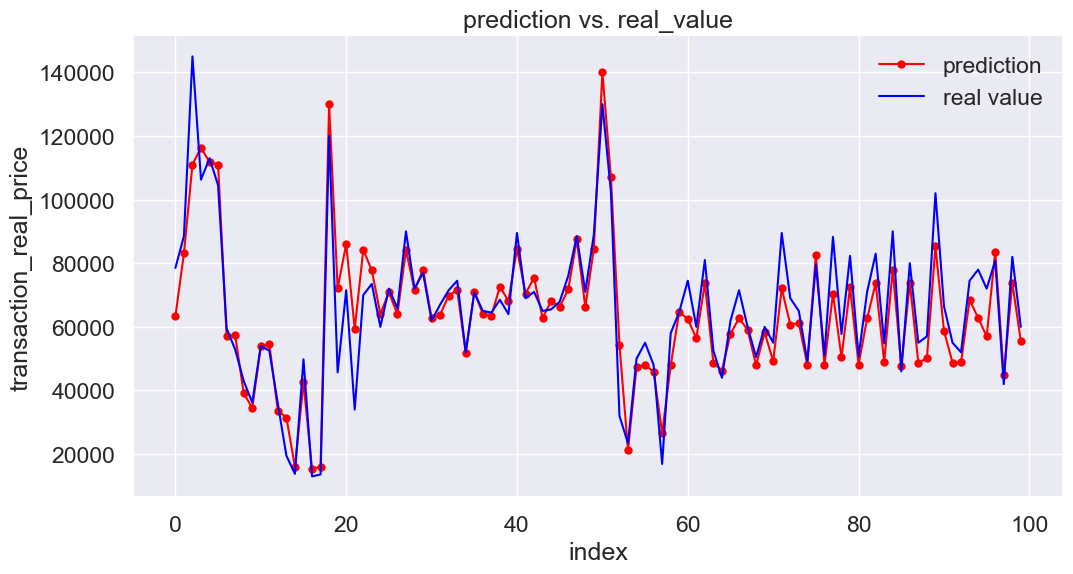

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.plot(prediction_lgb[:100], label='prediction', color='red', marker='o')
plt.plot(test_y.to_list()[:100], label='real value', color='blue', marker='x')
plt.title('prediction vs. real_value')
plt.xlabel('index')
plt.ylabel('transaction_real_price')
plt.legend()
plt.show()

#### 하이퍼파라미터 튜닝

In [32]:
from sklearn.model_selection import GridSearchCV

In [33]:
param_grid = [{
    'n_estimators': [100, 500, 1000],
    'max_depth' : [2,5,10,15,20,25,30,35,40]
               }]

In [34]:
grid_search = GridSearchCV(
    lgb_base,
    param_grid,
    cv=5,
    scoring = 'neg_root_mean_squared_error'
)
grid_search.fit(train_X, train_y)
print('Done.')

Done.


In [35]:
result = pd.DataFrame(grid_search.cv_results_)
result[['params', 'mean_test_score', 'rank_test_score']]

,params,split0_test_score,split1_test_score,mean_test_score,rank_test_score
0,"{'max_depth': 2, 'n_estimators': 100}",-14139.379468,-7559.087672,-14180.681702,27
1,"{'max_depth': 2, 'n_estimators': 500}",-12501.928096,-7431.340282,-12973.447779,26
2,"{'max_depth': 2, 'n_estimators': 1000}",-11883.073611,-6974.850980,-12346.047828,25
3,"{'max_depth': 5, 'n_estimators': 100}",-11322.630949,-7016.562903,-11914.335572,24
4,"{'max_depth': 5, 'n_estimators': 500}",-9534.496784,-5915.906697,-10285.362754,16
5,"{'max_depth': 5, 'n_estimators': 1000}",-9044.594430,-5534.839454,-9807.775190,8
6,"{'max_depth': 10, 'n_estimators': 100}",-10969.760686,-6795.997347,-11560.537866,18
7,"{'max_depth': 10, 'n_estimators': 500}",-9285.459904,-5837.884232,-10021.470177,15
8,"{'max_depth': 10, 'n_estimators': 1000}",-8859.708596,-5550.708945,-9642.490524,6
9,"{'max_depth': 15, 'n_estimators': 100}",-10886.384537,-6952.312445,-11548.798542,17


In [47]:
best_model = LGBMRegressor(n_estimators=1000, max_depth=20, random_state=1)
#best_model.fit(train_X, train_y)

models = []
scores = []
for model in [best_model]:
    model_name, mean_score = print_rmse_score(model)
    models.append(model_name)
    scores.append(mean_score)

LGBMRegressor Cross Validations...: 100%|██████████| 10/10 [00:20<00:00,  2.03s/it]

1 FOLDS: LGBMRegressor RMSE: 5043.2992
2 FOLDS: LGBMRegressor RMSE: 6539.0527
3 FOLDS: LGBMRegressor RMSE: 5593.4451
4 FOLDS: LGBMRegressor RMSE: 16069.8852
5 FOLDS: LGBMRegressor RMSE: 8392.2777
6 FOLDS: LGBMRegressor RMSE: 8953.5138
7 FOLDS: LGBMRegressor RMSE: 31881.8797
8 FOLDS: LGBMRegressor RMSE: 19697.1651
9 FOLDS: LGBMRegressor RMSE: 10651.1024
10 FOLDS: LGBMRegressor RMSE: 9497.4855

LGBMRegressor mean RMSE: 12231.9106


In [48]:
prediction_lgb = best_model.predict(test_X)

In [49]:
RMSE(test_y, prediction_lgb)

12584.49756353262

In [50]:
param_grid = [{
    'n_estimators': [1000],
    'max_depth' : [20],
    'num_leaves' : [31,61,81,100]
               }]

In [51]:
grid_search = GridSearchCV(
    lgb_base,
    param_grid,
    cv=5,
    scoring = 'neg_root_mean_squared_error'
)
grid_search.fit(train_X, train_y)
print('Done.')

Done.


In [52]:
result = pd.DataFrame(grid_search.cv_results_)
result[['params',  'mean_test_score', 'rank_test_score']]

,params,mean_test_score,rank_test_score
0,"{'max_depth': 20, 'n_estimators': 1000, 'num_l...",-9642.152772,4
1,"{'max_depth': 20, 'n_estimators': 1000, 'num_l...",-9463.084693,3
2,"{'max_depth': 20, 'n_estimators': 1000, 'num_l...",-9451.207112,2
3,"{'max_depth': 20, 'n_estimators': 1000, 'num_l...",-9395.410111,1


In [53]:
best_model = LGBMRegressor(n_estimators=1000, max_depth=15, num_leaves =100,random_state=1)
#best_model.fit(train_X, train_y)

models = []
scores = []
for model in [best_model]:
    model_name, mean_score = print_rmse_score(model)
    models.append(model_name)
    scores.append(mean_score)

LGBMRegressor Cross Validations...: 100%|██████████| 10/10 [00:33<00:00,  3.35s/it]

1 FOLDS: LGBMRegressor RMSE: 5274.3012
2 FOLDS: LGBMRegressor RMSE: 6877.7878
3 FOLDS: LGBMRegressor RMSE: 5047.6906
4 FOLDS: LGBMRegressor RMSE: 15928.3171
5 FOLDS: LGBMRegressor RMSE: 8636.0009
6 FOLDS: LGBMRegressor RMSE: 9044.1187
7 FOLDS: LGBMRegressor RMSE: 29536.9430
8 FOLDS: LGBMRegressor RMSE: 20148.9846
9 FOLDS: LGBMRegressor RMSE: 10565.6180
10 FOLDS: LGBMRegressor RMSE: 9337.5740

LGBMRegressor mean RMSE: 12039.7336


In [54]:
prediction_lgb = best_model.predict(test_X)

In [55]:
RMSE(test_y, prediction_lgb)

12776.05054682953

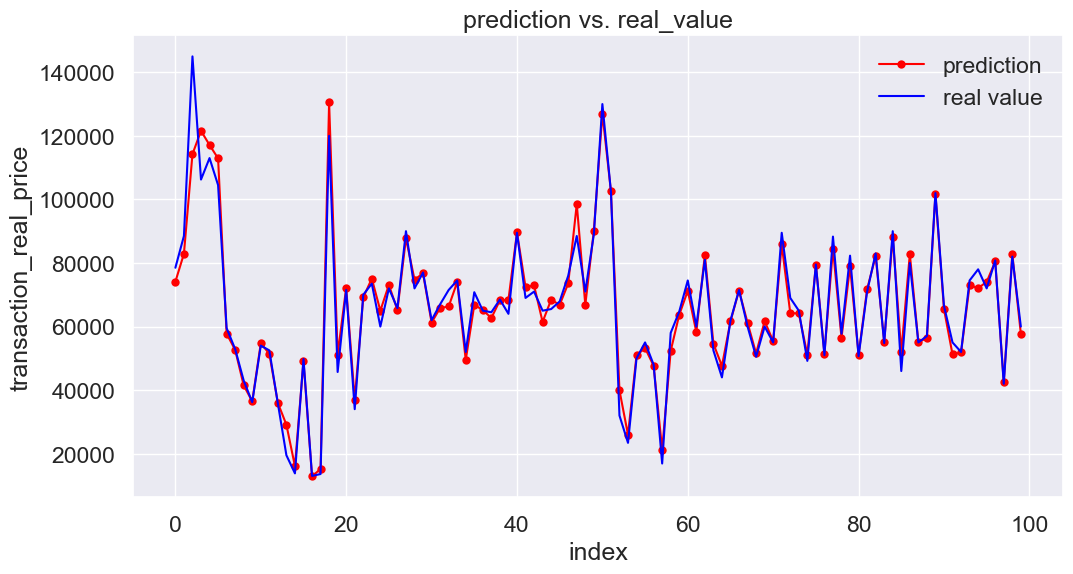

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.plot(prediction_lgb[:100], label='prediction', color='red', marker='o')
plt.plot(test_y.to_list()[:100], label='real value', color='blue', marker='x')
plt.title('prediction vs. real_value')
plt.xlabel('index')
plt.ylabel('transaction_real_price')
plt.legend()
plt.show()

In [60]:
param_grid = [{
    'n_estimators': [1000],
    'max_depth' : [20],
    'num_leaves' : [100],
    'min_child_samples' : [10, 15, 20, 40]
               }]

In [61]:
grid_search = GridSearchCV(
    lgb_base,
    param_grid,
    cv=5,
    scoring = 'neg_root_mean_squared_error'
)
grid_search.fit(train_X, train_y)
print('Done.')

Done.


In [62]:
result = pd.DataFrame(grid_search.cv_results_)
result[['params',  'mean_test_score', 'rank_test_score']]

,params,mean_test_score,rank_test_score
0,"{'max_depth': 20, 'min_child_samples': 10, 'n_...",-9394.841595,1
1,"{'max_depth': 20, 'min_child_samples': 15, 'n_...",-9414.540017,3
2,"{'max_depth': 20, 'min_child_samples': 20, 'n_...",-9395.410111,2
3,"{'max_depth': 20, 'min_child_samples': 40, 'n_...",-9430.446926,4


In [63]:
best_model = LGBMRegressor(n_estimators=1000, max_depth=15, num_leaves =100, min_child_samples= 10, random_state=1)
#best_model.fit(train_X, train_y)

models = []
scores = []
for model in [best_model]:
    model_name, mean_score = print_rmse_score(model)
    models.append(model_name)
    scores.append(mean_score)

LGBMRegressor Cross Validations...: 100%|██████████| 10/10 [00:34<00:00,  3.48s/it]

1 FOLDS: LGBMRegressor RMSE: 5181.5300
2 FOLDS: LGBMRegressor RMSE: 6905.1772
3 FOLDS: LGBMRegressor RMSE: 5136.7157
4 FOLDS: LGBMRegressor RMSE: 15002.1125
5 FOLDS: LGBMRegressor RMSE: 8768.7119
6 FOLDS: LGBMRegressor RMSE: 8817.0847
7 FOLDS: LGBMRegressor RMSE: 29884.2628
8 FOLDS: LGBMRegressor RMSE: 19178.8955
9 FOLDS: LGBMRegressor RMSE: 10946.3511
10 FOLDS: LGBMRegressor RMSE: 9166.5987

LGBMRegressor mean RMSE: 11898.7440


In [64]:
prediction_lgb = best_model.predict(test_X)

In [65]:
RMSE(test_y, prediction_lgb)

12574.938981649044

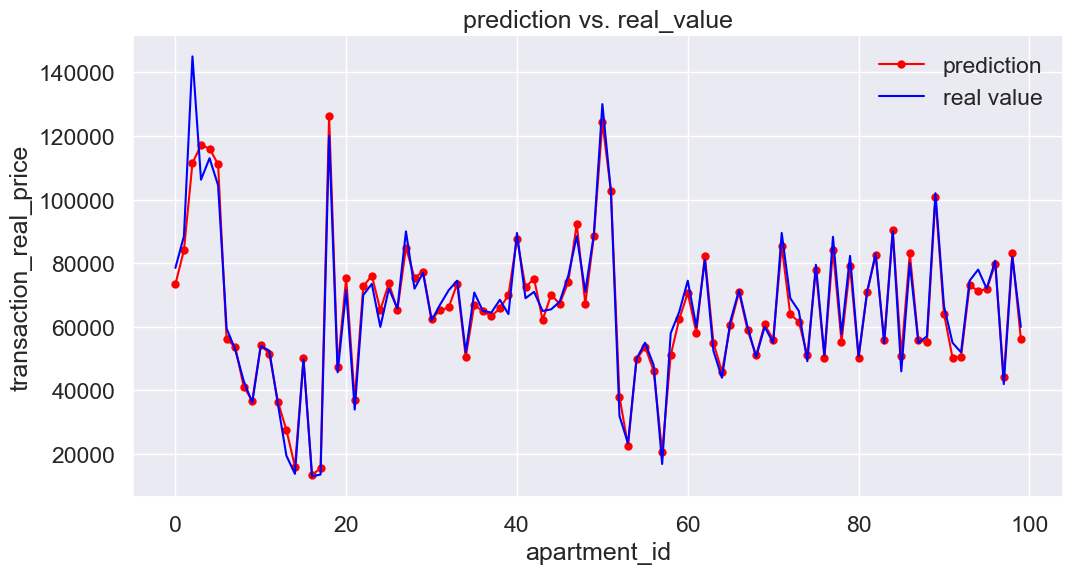

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.plot(prediction_lgb[:100], label='prediction', color='red', marker='o')
plt.plot(test_y.to_list()[:100], label='real value', color='blue', marker='x')
plt.title('prediction vs. real_value')
plt.xlabel('apartment_id')
plt.ylabel('transaction_real_price')
plt.legend()
plt.show()

#### SHAP

In [67]:
import shap

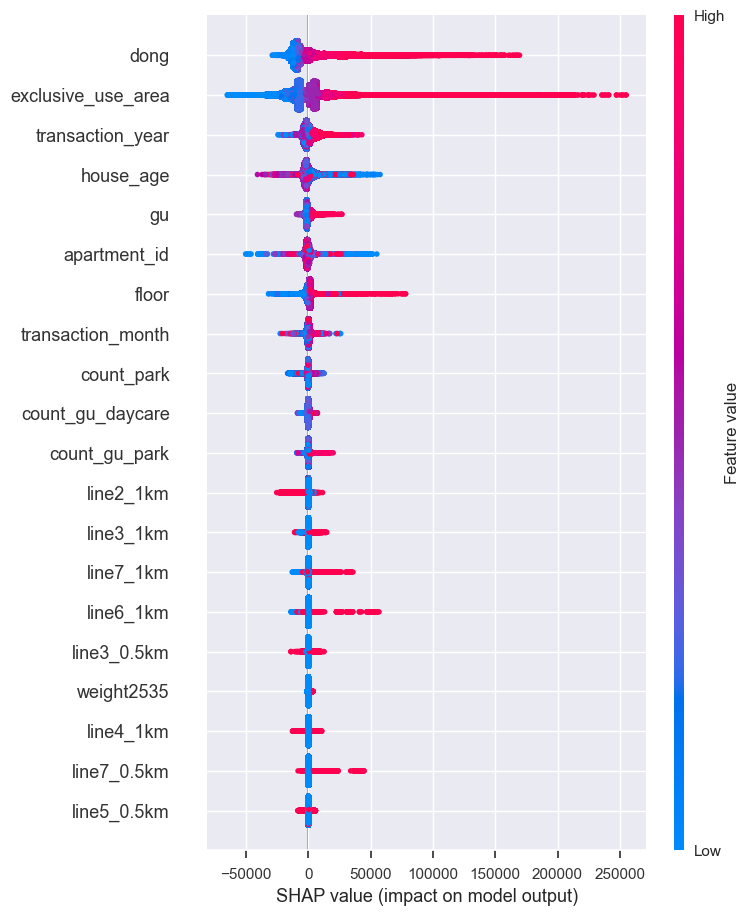

In [68]:
def shap_values(df, model):
    shap_values = shap.TreeExplainer(model).shap_values(df)
    shap.summary_plot(shap_values, df)

shap_values(train_X, best_model)